In [7]:
import os
import csv
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import textstat
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, f_regression, chi2
import seaborn as sns
from sklearn.utils import resample
from sklearn.decomposition import PCA
scaler = StandardScaler()

# Load the English language model
nlp = spacy.load("en_core_web_sm")

In [8]:
# This code block gives the comments in a formatted way which lets us convert to a dataframe
def get_comments(filepath):
    comments = []
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('#'):
                comments.append(line)
            else:
                break 
    return comments

def extract_info(comment):
    # Regular expression to extract difficulty, result, and tests from comments
    pattern = r"#\s+(\d+\.\d+)\s+(.+?)\s+(\d+/\d+)"

    match = re.match(pattern, comment)
    if match:
        return match.groups()
    return None

def find_gpt_files(directory):
    gpt_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file == 'gpt.py':
                gpt_files.append(os.path.join(root, file))
    return gpt_files

def save_comments_to_csv(comments, filename):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Difficulty", "Result", "Tests"])
        for comment in comments:
            info = extract_info(comment)
            if info:
                writer.writerow(info)

def main():
    kattis_dir = os.path.join(os.getcwd(), 'kattis')
    gpt_files = find_gpt_files(kattis_dir)
    all_comments = []

    for filepath in gpt_files:
        comments = get_comments(filepath)
        all_comments.extend(comments)

    if all_comments:
        csv_filename = 'kattis_comments.csv'
        save_comments_to_csv(all_comments, csv_filename)
        print(f"Comments saved to CSV file: {csv_filename}")
    else:
        print("No comments found in any gpt.py files.")

if __name__ == "__main__":
    main()

Comments saved to CSV file: kattis_comments.csv


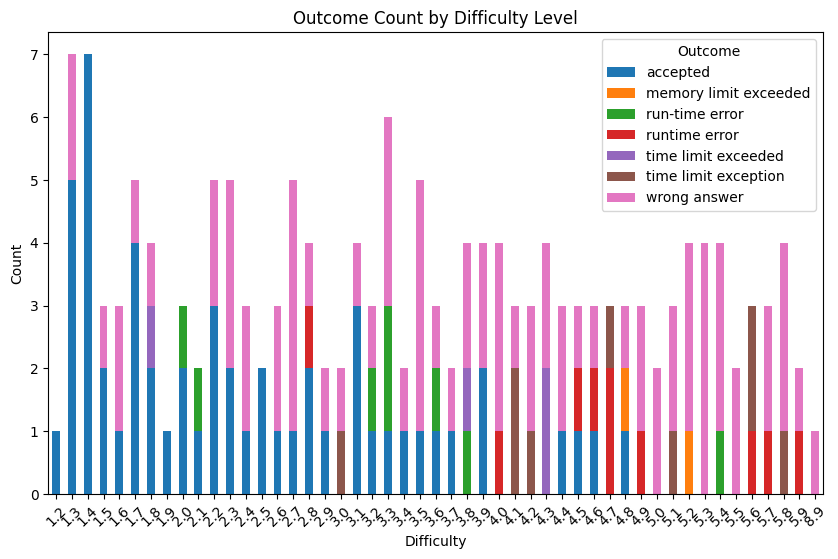

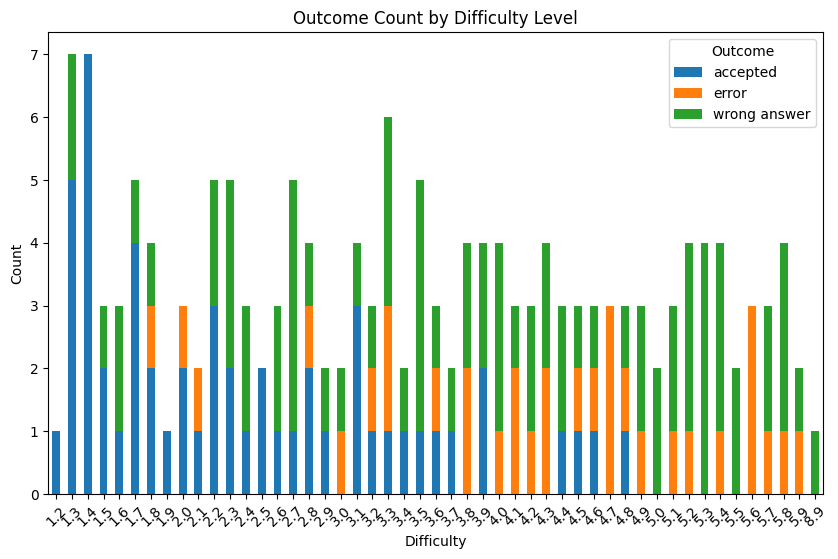

In [9]:
# Creating a dataframe from the comments csv
df_kattis = pd.read_csv("./kattis_comments.csv")
df_kattis['Result'] = df_kattis['Result'].apply(lambda x: x.lower() if isinstance(x, str) else x)

# Creating more columns for splitting the tests 
df_kattis[['Correct', 'Total']] = df_kattis['Tests'].str.split('/',expand=True).astype(int)

# Getting the count of each result at the difficulties
grouped = df_kattis.groupby(['Difficulty','Result']).size().unstack(fill_value=0)
# display(grouped)

# Creating a stacked bar chart for each result at each difficulty
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_xlabel('Difficulty')
ax.set_ylabel('Count')
ax.set_title('Outcome Count by Difficulty Level')
plt.xticks(rotation=45)
plt.legend(title='Outcome')
plt.show()

# making all errors to be a general error and plotting again
df_kattis['Result'] = df_kattis['Result'].apply(lambda x: 'error' if isinstance(x, str) and x.lower().split()[-1] in ['error', 'exceeded', 'exception'] else x)

# Getting the count of each result at the difficulties
grouped = df_kattis.groupby(['Difficulty','Result']).size().unstack(fill_value=0)
# Creating a stacked bar chart for each result at each difficulty
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_xlabel('Difficulty')
ax.set_ylabel('Count')
ax.set_title('Outcome Count by Difficulty Level')
plt.xticks(rotation=45)
plt.legend(title='Outcome')
plt.show()
# Figure out which feutures to have as inputs in a prediction model, Figure engineering. With what to get from the problem statements. Readability, frequency of words, etc. think of meaningful features. perform unsupervised learning, understanding the features.

In [28]:
df_kattis[:10]

,Difficulty,Result,Tests,Correct,Total
0,3.0,wrong answer,1/19,1,19
1,3.3,error,0/3,0,3
2,2.7,wrong answer,2/19,2,19
3,4.0,wrong answer,0/13,0,13
4,2.0,accepted,52/52,52,52
5,2.3,wrong answer,0/12,0,12
6,2.4,wrong answer,0/2,0,2
7,3.8,error,0/92,0,92
8,1.7,wrong answer,0/7,0,7
9,3.9,accepted,11/11,11,11


## Collecting Prompts

In [11]:
# Functions to get all problems
def find_prompt_files(directory):
    prompt_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if 'gpt_prompt' in file:  # Check if 'gpt_prompt' is in the file name
                prompt_files.append(os.path.join(root, file))
    return prompt_files

def get_problem(filepath):
    with open(filepath, 'r') as f:
        problem = f.read().strip()
    return [problem]

kattis_dir = os.path.join(os.getcwd(), 'kattis')
prompt_files = find_prompt_files(kattis_dir)
all_problems = []

for filepath in prompt_files:
    comments = get_problem(filepath)
    all_problems.extend(comments)

all_problems[0]


'2048 is a single-player puzzle game created by Gabriele Cirulli1. It is played on a 4x4  grid that contains integers >=2 that are powers of 2. The player can use a keyboard arrow key (left/up/right/down) to move all the tiles simultaneously. Tiles slide as far as possible in the chosen direction until they are stopped by either another tile or the edge of the grid. If two tiles of the same number collide while moving, they will merge into a tile with the total value of the two tiles that collided. The resulting tile cannot merge with another tile again in the same move. Please observe this merging behavior carefully in all Sample Inputs and Outputs.\n\nInput\nThe input is always a valid game state of a 2048 puzzle. The first four lines of input, that each contains four integers, describe the 16 integers in the 4x4 grid of 2048 puzzle. The j-th integer in the i-th line denotes the content of the cell located at the i-th row and the j-th cell. For this problem, all integers in the input

In [12]:
 # Look into another filter for words that are important
data = []
terms = set()
with open("programming_terms.txt", "r") as file:
    for line in file:
        # Split the line into terms using comma as delimiter
        term_list = line.strip().lower().split(',')
        # Add each term to the set
        for term in term_list:
            terms.add(term.strip())

for problem in all_problems:
        doc = nlp(problem)
        # Extract keywords (nouns and verbs) excluding stopwords
        keywords = [token.text.lower() for token in doc if token.text.lower() not in STOP_WORDS
                    and token.text.lower() in terms
                    and token.pos_ not in ['SYM', 'PUNCT', 'SPACE', 'X']]
        # Count the frequency of each keyword
        keyword_freq = Counter(keywords)
        # Print the top keywords and their frequencies
        data.append(keyword_freq)

df = pd.DataFrame(data)
df = df.fillna(0)
df

,integer,binary,class,implementation,string,algorithm,protocol,testing,variable,stack,network,maintenance,object,array,cryptography,tree,bit,queue,graph,function
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0


In [13]:
# Do all textstat readability and find best features from them
with open("output.csv", mode="w", newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["ARI", "DCR", "DCR_V2", "FRE", "FKG", "SMOG", "CLI", "LINSEAR", "GF", "Textstd", "LexCount", "Difficult Words"])

    for problem in all_problems:
        ARI = textstat.automated_readability_index(problem)
        DCR = textstat.dale_chall_readability_score(problem)
        DCR_v2 = textstat.dale_chall_readability_score_v2(problem)
        FRE = textstat.flesch_reading_ease(problem)
        FKG = textstat.flesch_kincaid_grade(problem)
        SMOG = textstat.smog_index(problem)
        CLI = textstat.coleman_liau_index(problem)
        LINSEAR = textstat.linsear_write_formula(problem)
        GF = textstat.gunning_fog(problem)
        txtstd = textstat.text_standard(problem, float_output=False)
        lex_count = textstat.lexicon_count(problem, removepunct=True)
        difficult_words = textstat.difficult_words(problem)
        info = ARI, DCR, DCR_v2, FRE, FKG, SMOG, CLI, LINSEAR, GF, txtstd, lex_count, difficult_words
        writer.writerow(info)
        



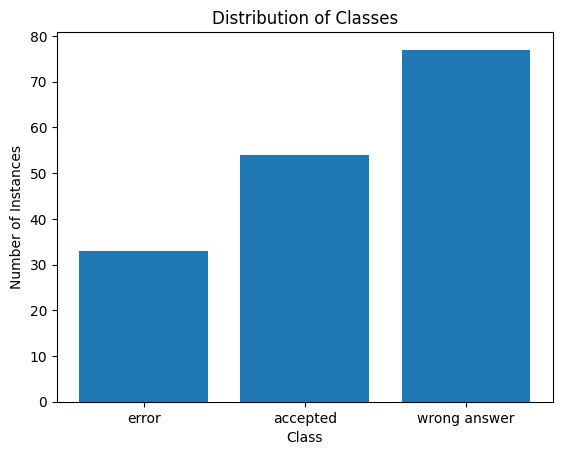

In [14]:
# Adopt one-hot encoding for y values: wrong, accepted, error
# cross-validation techniques
# grid search: model training
# Select K-best, PCA
# Checking imbalance dataset
# work on word frequency
# Use up-sampling for the errors

# Look at the scores to determine features
# Use histogram to show imbalance

#creating dataframe from features
features = pd.read_csv("./output.csv")
# Adding problem difficulties to features
features['Difficulty'] = df_kattis['Difficulty']
# Check unique values in the 'Textstd' column
unique_values = features['Textstd'].unique()

# Representing textstd numerically using a map
textstd_map = {
    '3rd and 4th grade': 1,
    '4th and 5th grade': 2, 
    '5th and 6th grade': 3,
    '6th and 7th grade': 4,
    '7th and 8th grade': 5,
    '8th and 9th grade': 6,
    '9th and 10th grade': 7,
    '10th and 11th grade': 8, 
    '11th and 12th grade': 9,
    '12th and 13th grade': 10,
    '18th and 19th grade': 11,
}
features['Textstd'] = features['Textstd'].map(textstd_map)
# Adding result column to features
features['Result'] = df_kattis['Result']

# Encode the results 
encoder = OneHotEncoder()
result_encoded = encoder.fit_transform(features[['Result']])

# Convert the sparse matrix to a DataFrame
result_df = pd.DataFrame.sparse.from_spmatrix(result_encoded, columns=encoder.categories_[0])
# Concatenate the one-hot encoded target variable with the original DataFrame
df_encoded = pd.concat([features, result_df], axis=1)
# Drop the original 'Result' column
df_encoded.drop('Result', axis=1, inplace=True)

scaled_features = scaler.fit_transform(df_encoded.drop(['accepted', 'wrong answer', 'error'], axis=1))
scaled_features = pd.DataFrame(scaled_features, columns=df_encoded.drop(['accepted', 'wrong answer', 'error'], axis=1).columns)

result_encoded = df_encoded[['accepted', 'wrong answer', 'error']]

X = scaled_features
y = result_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y.values)

# Combine X_train and y_train into a single DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

# Count the occurrences of each class
class_counts = result_encoded[['error', 'accepted', 'wrong answer']].sum()

# Create a bar plot
plt.bar(class_counts.index, class_counts.values)

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Distribution of Classes')

# Show plot
plt.show()

# Separate minority and majority classes
error_data = train_data[train_data['error'] == 1]
accepted_data = train_data[train_data['accepted'] == 1]
wrong_data = train_data[train_data['wrong answer'] == 1]

# Upsample minority class
error_data_upsampled = resample(error_data, random_state=42, replace=True, n_samples=len(wrong_data))
accepted_data_upsampled = resample(accepted_data, random_state=42, replace=True, n_samples=len(wrong_data))

# Combine majority class with upsampled minority class
upsampled_data = pd.concat([error_data_upsampled, accepted_data_upsampled, wrong_data])

# Separate features and target variable
X_train_upsampled = upsampled_data.drop(['accepted', 'wrong answer' , 'error'], axis=1)
y_train_upsampled = upsampled_data[['accepted','wrong answer','error']].values.argmax(axis=1)


## Select K-best

            Feature      Score
12       Difficulty  45.325946
10         LexCount  12.541353
11  Difficult Words   6.577747
1               DCR   5.593956
2            DCR_V2   2.460490
7           LINSEAR   2.238279
5              SMOG   1.591769
6               CLI   1.276177


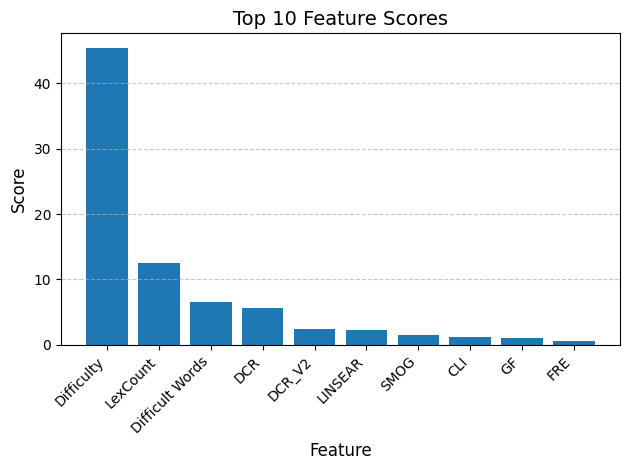

In [15]:

bestfeatures = SelectKBest(score_func=f_classif, k=3)
fit = bestfeatures.fit(X_train_upsampled.values,y_train_upsampled)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(features.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']
print(featureScores.nlargest(8,'Score'))

top_10_scores = featureScores.nlargest(10, 'Score')

# Extract the feature names and scores
feature_names = top_10_scores['Feature'].to_numpy()
scores = top_10_scores['Score'].to_numpy()

# Create a bar chart
plt.bar(feature_names, scores)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Increase the font size for x-axis labels
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Top 10 Feature Scores', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [16]:
# select top 4 features using f_classif
selector = SelectKBest(f_classif, k=4)
X_new = selector.fit_transform(X_train_upsampled.values, y_train_upsampled)
# print(X_new)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the hyperparameters you want to tune
param_grid = {
    'C': np.linspace(0.1, 1, 100),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000]
}


# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    verbose=1,  # Print progress
    scoring='f1_micro'  # Use accuracy as the evaluation metric, if imbalanced use f1 score instead
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_new, y_train_upsampled)

# Get the best hyperparameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model found by GridSearchCV
best_model = grid_search.best_estimator_

cross_val_results = cross_val_score(best_model, X_new, y_train_upsampled, cv=kfold)
   
print(f'Cross-Validation Results (f1): {cross_val_results}')
print(f'Mean Accuracy: {cross_val_results.mean()}')

X_test_selected = selector.fit_transform(X_test, y_test.values.argmax(axis=1))

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_selected)

# Generate and print the classification report
report = classification_report(y_test.values.argmax(axis=1), y_pred, zero_division=1)
print("SelectKBest Classification Report:")
print(report)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Best Hyperparameters: {'C': 0.9818181818181817, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Cross-Validation Results (f1): [0.65789474 0.56756757 0.56756757 0.54054054 0.64864865]
Mean Accuracy: 0.5964438122332859
SelectKBest Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.78      0.47      0.58        15
           2       0.40      0.86      0.55         7

    accuracy                           0.64        33
   macro avg       0.69      0.68      0.64        33
weighted avg       0.73      0.64      0.65        33



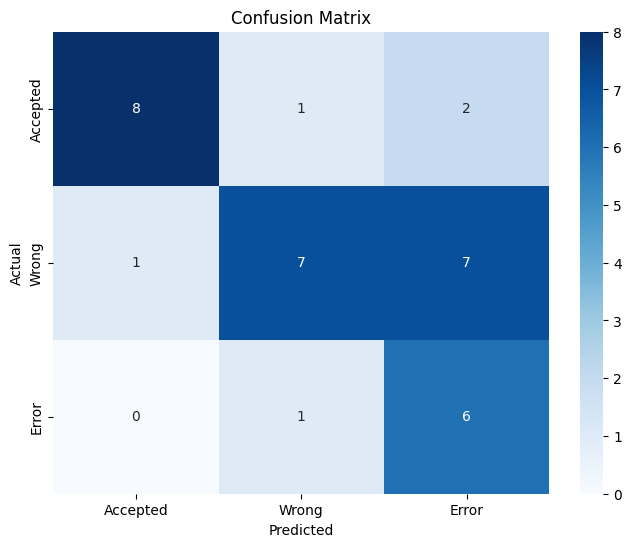

In [17]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test.values.argmax(axis=1), y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Accepted', 'Wrong', 'Error'],
            yticklabels=['Accepted', 'Wrong', 'Error'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## PCA

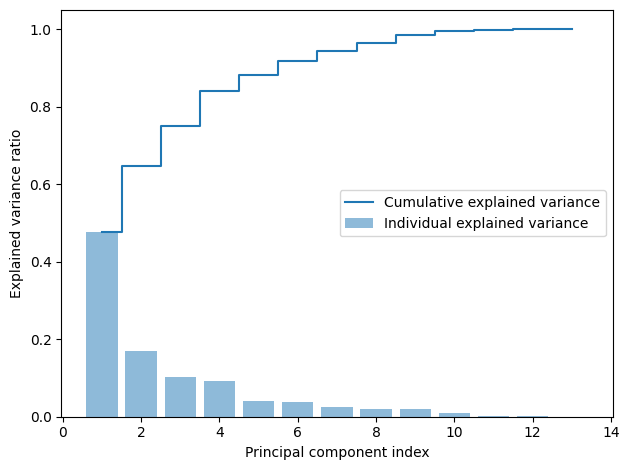

In [18]:
pca = PCA().fit(X_train_upsampled)
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center',
       label='Individual explained variance')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()

In [19]:
pca = PCA(n_components=6)

X_pca = pca.fit_transform(X_train_upsampled)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)


# Define the hyperparameters you want to tune
param_grid = {
    'C': np.logspace(-3,3,100),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    verbose=1,  # Print progress
    scoring='f1_micro'  # Use accuracy as the evaluation metric, if imbalanced use f1 score instead
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_pca, y_train_upsampled)

# Get the best hyperparameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model found by GridSearchCV
best_model = grid_search.best_estimator_

cross_val_results = cross_val_score(best_model, X_pca, y_train_upsampled, cv=kfold)
   
print(f'Cross-Validation Results (f1): {cross_val_results}')
print(f'Mean Accuracy: {cross_val_results.mean()}')

X_test_PCA = pca.transform(X_test)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_PCA)

# Generate and print the classification report
report = classification_report(y_test.values.argmax(axis=1), y_pred, zero_division=1)
print("PCA Classification Report:")
print(report)


Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Best Hyperparameters: {'C': 0.5336699231206312, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Cross-Validation Results (f1): [0.71052632 0.54054054 0.45945946 0.51351351 0.64864865]
Mean Accuracy: 0.5745376955903272
PCA Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.82      0.60      0.69        15
           2       0.45      0.71      0.56         7

    accuracy                           0.67        33
   macro avg       0.67      0.68      0.66        33
weighted avg       0.71      0.67      0.67        33



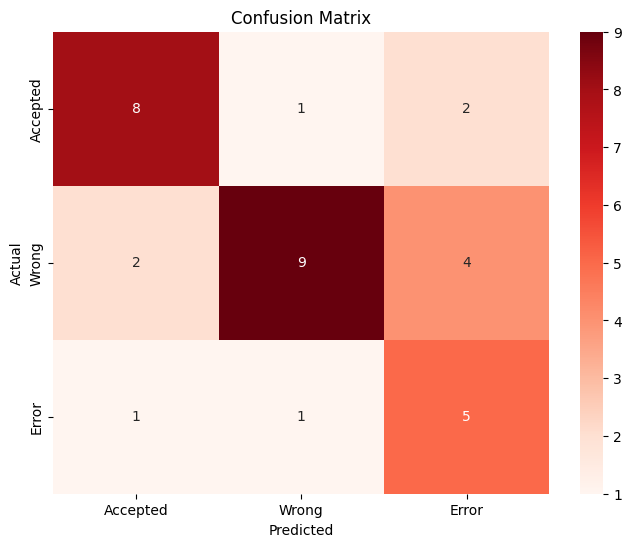

In [20]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test.values.argmax(axis=1), y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Accepted', 'Wrong', 'Error'],
            yticklabels=['Accepted', 'Wrong', 'Error'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Kmeans Cluster

In [21]:
# # Adopt one-hot encoding for y values: wrong, accepted, error
# # cross-validation techniques
# # grid search: model training
# # Select K-best, PCA
# # Checking imbalance dataset
# # work on word frequency
# # Use up-sampling for the errors

# #creating dataframe from features
# features = pd.read_csv("./output.csv")

# # Adding problem difficulties to features
# features['Difficulty'] = df_kattis['Difficulty']

# # Check unique values in the 'Textstd' column
# unique_values = features['Textstd'].unique()

# # Representing textstd numerically using a map
# textstd_map = {
#     '3rd and 4th grade': 1,
#     '4th and 5th grade': 2, 
#     '5th and 6th grade': 3,
#     '6th and 7th grade': 4,
#     '7th and 8th grade': 5,
#     '8th and 9th grade': 6,
#     '9th and 10th grade': 7,
#     '10th and 11th grade': 8, 
#     '11th and 12th grade': 9,
#     '12th and 13th grade': 10,
#     '18th and 19th grade': 11,
# }
# features['Textstd'] = features['Textstd'].map(textstd_map)
# scaled_features = scaler.fit_transform(features)
# scaled_features = pd.DataFrame(scaled_features, columns=features.columns)

# X = scaled_features.values

# inertia_values = []

# # Trying to find optimal k value
# k_values = range(1, 11)
# for k in k_values:
#     kmeans = KMeans(n_clusters=k, init='k-means++')
#     kmeans.fit(X)
#     inertia_values.append(kmeans.inertia_)

# # converting the results into a dataframe and plotting them
# frame = pd.DataFrame({'Cluster':range(1,11), 'Inertia values':inertia_values})
# plt.figure(figsize=(12,6))
# plt.plot(frame['Cluster'], frame['Inertia values'], marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia')

In [22]:
# k = 4
# kmeans = KMeans(n_clusters=k, init='k-means++')
# kmeans.fit(X)

# # Get cluster labels for each feature
# feature_clusters = kmeans.labels_

# # Select one representative feature from each cluster
# representative_features = []
# for cluster_id in range(k):
#     cluster_indices = [i for i, cluster_label in enumerate(feature_clusters) if cluster_label == cluster_id and i < len(features.columns)]
#     if len(cluster_indices) > 0:
#         cluster_features = features.iloc[:, cluster_indices]
#         cluster_center_label = cluster_features.mean(axis=0).idxmin()  # Select feature closest to cluster center (label)
#         cluster_center_index = features.columns.get_loc(cluster_center_label)  # Convert label to integer index
#         representative_features.append(features.columns[cluster_center_index])


# # Select the representative features
# selected_features = features[representative_features]

# print("Selected Features:", selected_features.shape[1])

# plt.figure(figsize=(10, 6))
# plt.bar(range(len(representative_features)), representative_features)
# plt.xlabel('Cluster')
# plt.ylabel('Feature Index')
# plt.title('Representative Features for Each Cluster')
# plt.show()

In [23]:
# # Creating a loop to find which feature are most represent clusters
# k = 4
# num_runs = 10
# feature_counts = Counter()
# for _ in range(num_runs):
#     kmeans = KMeans(n_clusters=k, init='k-means++')
#     kmeans.fit(X)

# # Get cluster labels for each feature
#     feature_clusters = kmeans.labels_
#     representative_features = []
#     for cluster_id in range(k):
#         cluster_indices = [i for i, cluster_label in enumerate(feature_clusters) if cluster_label == cluster_id and i < len(features.columns)]
#         if len(cluster_indices) > 0:
#             cluster_features = features.iloc[:, cluster_indices]
#             cluster_center_label = cluster_features.mean(axis=0).idxmin()  # Select feature closest to cluster center (label)
#             cluster_center_index = features.columns.get_loc(cluster_center_label)  # Convert label to integer index
#             representative_features.append(features.columns[cluster_center_index])
#     for feature in representative_features:
#         feature_counts[feature] += 1
        
# print("Feature Counts:")
# for feature, count in feature_counts.items():
#   print(f"{feature}: {count} appearances")

# # Important features from kmeans cluster: Difficulty, DCR_V2, GF, these three always appear with max count, fkg and textstd follow behind them
# # Model accuracy using these five: 58%
# # difficulty, textstd, and gf are the most representative features with scaling
# # model accuracy with new three representative features: 61%


## Logistic Regression 

In [24]:
# rep_features = features[['Textstd','GF','Difficulty']]
# rep_features['Result'] = df_kattis['Result']

# encoder = OneHotEncoder()
# result_encoded = encoder.fit_transform(rep_features[['Result']])

# # Convert the sparse matrix to a DataFrame
# result_df = pd.DataFrame.sparse.from_spmatrix(result_encoded, columns=encoder.categories_[0])

# # Concatenate the one-hot encoded target variable with the original DataFrame
# df_encoded = pd.concat([rep_features, result_df], axis=1)

# # Drop the original 'Result' column
# df_encoded.drop('Result', axis=1, inplace=True)

# #print(df_encoded)

# scaled_df = scaler.fit_transform(df_encoded.drop(['accepted', 'wrong answer', 'error'], axis=1))
# scaled_df = pd.DataFrame(scaled_df, columns=df_encoded.drop(['accepted', 'wrong answer', 'error'], axis=1).columns)

# X = scaled_df.values
# y = df_encoded[['accepted', 'wrong answer', 'error']].values  # Target variable

# # Creating the training, testing, and validation sets
# X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# # Technique for validation: k-fold cross-validation
# X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# # Print the shapes of the resulting datasets
# print("Training set:", X_train.shape, y_train.shape)
# print("Validation set:", X_val.shape, y_val.shape)
# print("Test set:", X_test.shape, y_test.shape)

# # Create a logistic regression model
# model = LogisticRegression(max_iter=1000)  

# # Convert the one-hot encoded target variable to a 1D array
# y_train_labels = y_train.argmax(axis=1)

# # Train the model on the training set
# model.fit(X_train, y_train_labels)

# # Make predictions on the validation set
# y_val_pred = model.predict(X_val)

# y_val_labels = y_val.argmax(axis=1)

# # Evaluate the model on the validation set
# val_accuracy = accuracy_score(y_val_labels, y_val_pred)
# print("Validation Accuracy:", val_accuracy)

# # Print classification report for the validation set
# print("Classification Report for Validation Set:")
# print(classification_report(y_val_labels, y_val_pred))

# # Get a count for each result in the dataset, checks for imbalance dataset, up-sampling


In [25]:
# # Define the hyperparameters you want to tune
# param_grid = {
#     'C': np.logspace(-3,3,7),
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear', 'saga'],
#     'max_iter': [100, 500, 1000]
# }

# # Create the GridSearchCV object
# grid_search = GridSearchCV(
#     estimator=LogisticRegression(),
#     param_grid=param_grid,
#     cv=5,  # 5-fold cross-validation
#     n_jobs=-1,  # Use all available CPU cores
#     verbose=1,  # Print progress
#     scoring='accuracy'  # Use accuracy as the evaluation metric, if imbalanced use f1 score instead
# )

# # Fit the GridSearchCV object to the training data
# grid_search.fit(X_train, y_train_labels)

# # Get the best hyperparameters found by GridSearchCV
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

# # Get the best model found by GridSearchCV
# best_model = grid_search.best_estimator_

# # Evaluate the best model on the validation set
# y_val_pred = best_model.predict(X_val)
# val_accuracy = accuracy_score(y_val_labels, y_val_pred)
# print("Validation Accuracy with Best Model:", val_accuracy)

# # Print classification report for the validation set using the best model
# print("Classification Report for Validation Set with Best Model:")
# print(classification_report(y_val_labels, y_val_pred, zero_division=1))


In [26]:
# # Get the predicted probabilities for the validation set
# y_val_prob = best_model.predict_proba(X_val)

# # Plot the predicted probabilities for each class
# plt.figure(figsize=(12, 6))
# barWidth = 0.25
# bars1 = y_val_prob[:, 0]
# bars2 = y_val_prob[:, 1]
# bars3 = y_val_prob[:, 2]

# r1 = np.arange(len(bars1))
# r2 = [x + barWidth for x in r1]
# r3 = [x + barWidth for x in r2]

# plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='grey', label='accepted')
# plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='grey', label='wrong answer')
# plt.bar(r3, bars3, color='g', width=barWidth, edgecolor='grey', label='error')

# plt.xlabel('Samples', fontweight='bold')
# plt.ylabel('Predicted Probability', fontweight='bold')
# plt.xticks([r + barWidth for r in range(len(bars1))], range(len(bars1)))
# plt.title('Predicted Probabilities for Each Class')
# plt.legend()
# plt.show()

In [27]:
# # Get the predicted labels for the validation set
# y_val_pred = best_model.predict(X_val)

# # Create a confusion matrix
# conf_matrix = confusion_matrix(y_val_labels, y_val_pred)

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['accepted', 'wrong answer', 'error'], yticklabels=['accepted', 'wrong answer', 'error'])
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()